In [ ]:
import json
import sys
sys.path.append('/Users/wastechs/Documents/git-repos/energy-efficiency')
from validation.gp.create_train_inference import create_train_inference_gp
from lib.util import helper, data_preprocessing
import torch
import gpytorch
from itertools import combinations

### Preprocess Data

In [11]:
X_train, y_train, X_test, y_test, n_train = data_preprocessing.gp_preprocess(
    machine='entsorgung_30T', 
    freq=30,
    normalize_time=True,
    )

In [9]:
## Locally Periodic Kernel ##
period_constraint_short = gpytorch.constraints.Interval(0.08, 0.11) ## short term

seasonal_periodic_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_short
        )
    )

seasonal_rbf_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_short_periodic = seasonal_periodic_short * seasonal_rbf_short

period_constraint_long = gpytorch.constraints.Interval(0.18, 0.21) ## long term

seasonal_periodic_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_long
        )
    )

seasonal_rbf_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_long_periodic = seasonal_periodic_long * seasonal_rbf_long

## Local Variations ##
local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)

local_variation = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RQKernel()
    )
    
local_variation.alpha = local_variation_alpha

local_variation_2 = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
    )

covar = locally_long_periodic + local_variation


covar_module1 = locally_short_periodic + locally_long_periodic + local_variation 
covar_module2 = locally_short_periodic
covar_module3 = locally_short_periodic + local_variation 
covar_module4 = locally_short_periodic + locally_long_periodic

covar_module5 = locally_long_periodic
covar_module6 = locally_long_periodic + local_variation 

covar_module7 = local_variation

covar_combinations = [
    covar_module1, covar_module2, covar_module3, 
    covar_module4, covar_module5, covar_module6, 
    covar_module7]


### Create, Train, and Perform Inference

In [ ]:

for kernel in covar_combinations:

    X_train, y_train, X_test, y_test, n_train = data_preprocessing.gp_preprocess(
    machine='entsorgung_30T', 
    freq=30,
    normalize_time=True)

    
    func_preds_mean_inv, func_preds_var_inv, observed_preds, mse, mape = create_train_inference_gp(
    kernel_gen=kernel,
    train_x=X_train,
    train_y=y_train,
    test_x=X_test,
    test_y=y_test,
    n_train=n_train,
    training_iter=100,
    lr=0.1, 
    time_agg='30T',
    machine='entsorgung',
    update_score=True
)

Iter 1 , Loss = 0.9136920232533744 , Noise = 0.6932471990585327
Iter 2 , Loss = 0.8765016919436307 , Noise = 0.6444966793060303
Iter 3 , Loss = 0.8402217868096008 , Noise = 0.5982147455215454
Iter 4 , Loss = 0.8033681584513319 , Noise = 0.5543758869171143
Iter 5 , Loss = 0.7661143419199089 , Noise = 0.5129457116127014
Iter 6 , Loss = 0.7289861367115824 , Noise = 0.47388210892677307
Iter 7 , Loss = 0.6920069548950725 , Noise = 0.43713685870170593
Iter 8 , Loss = 0.6549864806213502 , Noise = 0.4026547074317932
Iter 9 , Loss = 0.6180158358986622 , Noise = 0.3703732192516327
Iter 10 , Loss = 0.5812851602845557 , Noise = 0.3402235507965088
Iter 11 , Loss = 0.5447660219331139 , Noise = 0.31213149428367615
Iter 12 , Loss = 0.5083355205929928 , Noise = 0.28601765632629395
Iter 13 , Loss = 0.47213187045160737 , Noise = 0.2617974281311035
Iter 14 , Loss = 0.4362955191012769 , Noise = 0.23938274383544922
Iter 15 , Loss = 0.4006909851935103 , Noise = 0.21868328750133514
Iter 16 , Loss = 0.36524074

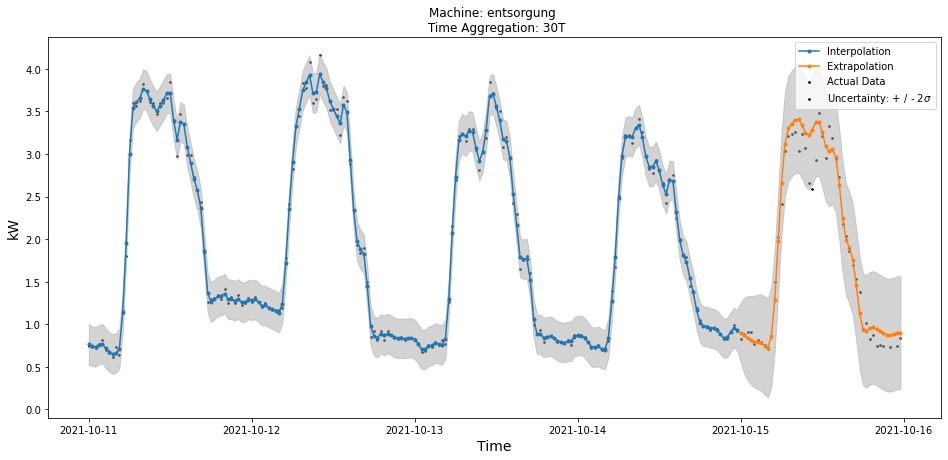

Empty DataFrame
Columns: [time, actual, machine]
Index: []


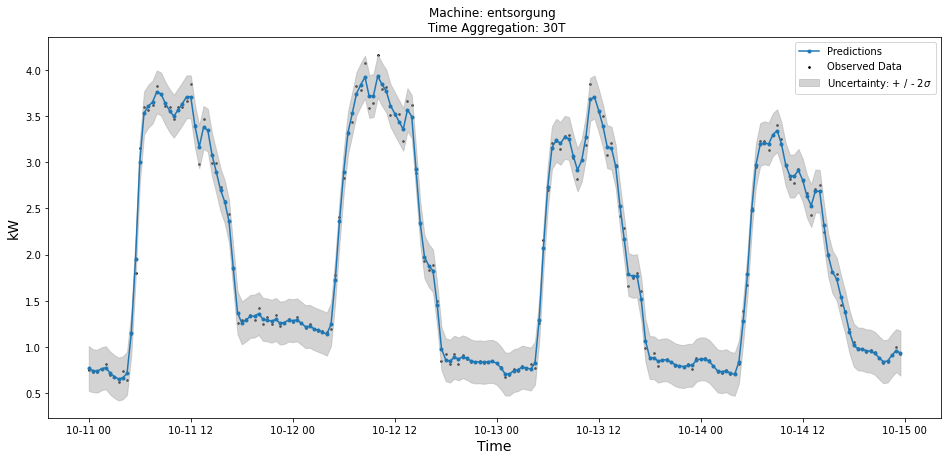

   index                time     machine control_limit  actual_kw  \
0      0 2021-10-15 10:30:00  entsorgung         lower   2.590947   

   expected_kw     bound  
0       3.2796  2.641524  


/Users/wastechs/Documents/git-repos/energy-efficiency/validation/gp/create_train_inference.py:510: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ax[0].scatter(orig_time[upper], deviation[upper], color='red')
/Users/wastechs/Documents/git-repos/energy-efficiency/validation/gp/create_train_inference.py:511: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ax[0].scatter(orig_time[lower], deviation[lower], color='red')


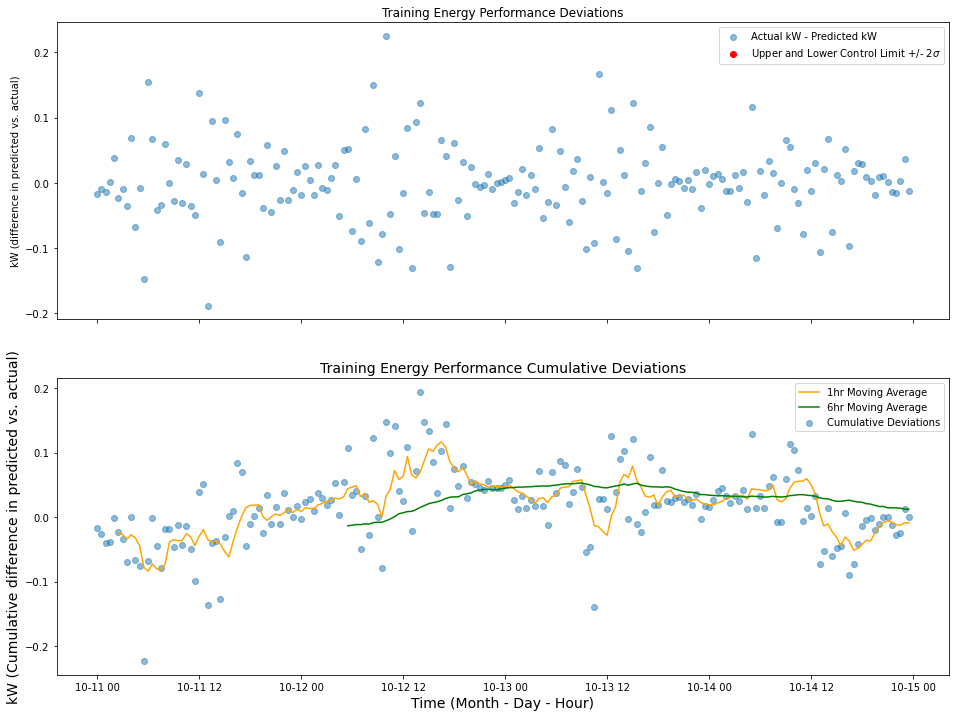

/Users/wastechs/Documents/git-repos/energy-efficiency/validation/gp/create_train_inference.py:537: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ax[0].scatter(test_time[test_upper], test_deviation[test_upper], color='red')
/Users/wastechs/Documents/git-repos/energy-efficiency/validation/gp/create_train_inference.py:538: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ax[0].scatter(test_time[test_lower], test_deviation[test_lower], color='red')


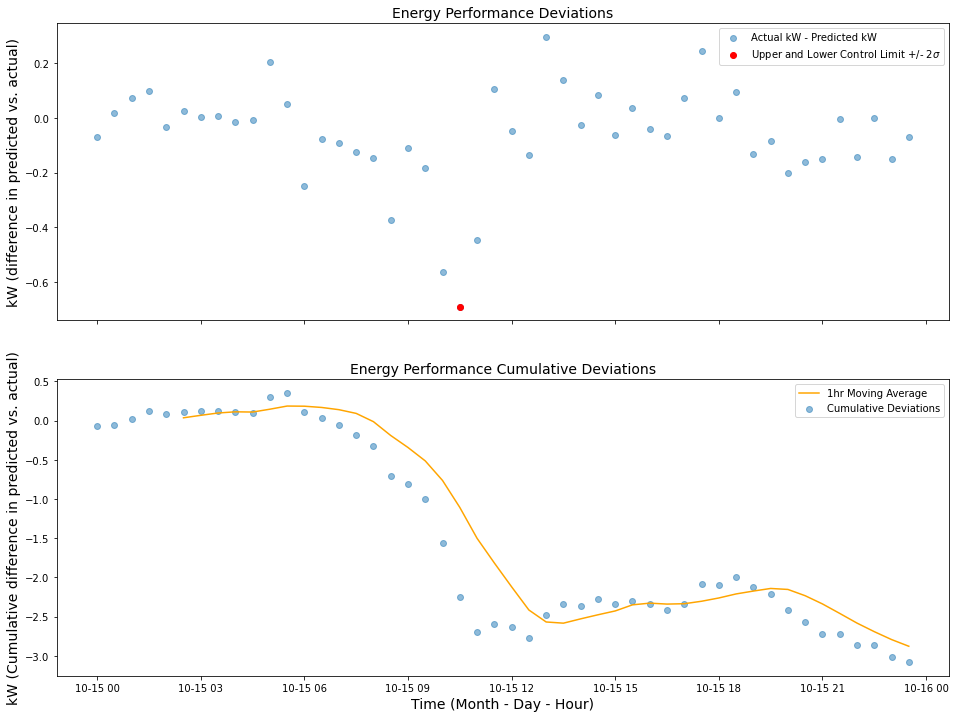

0.9791666666666666 0.06457827224048486


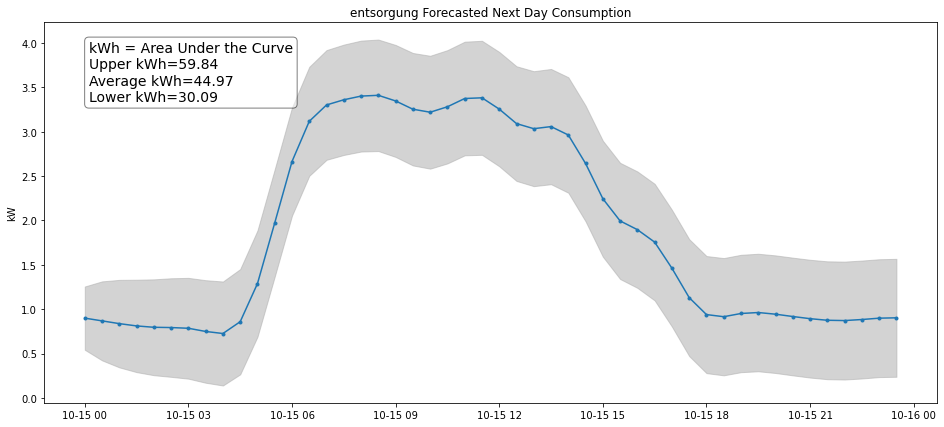

In [12]:
func_preds_mean_inv, func_preds_var_inv, observed_preds, mse, mape = create_train_inference_gp(
    kernel_gen=covar_module6,
    train_x=X_train,
    train_y=y_train,
    test_x=X_test,
    test_y=y_test,
    n_train=n_train,
    training_iter=100,
    lr=0.1, 
    time_agg='30T',
    machine='entsorgung',
    update_score=False
)

In [ ]:
mse, mape

### 5 minutes agg.

In [ ]:
X_train, y_train, X_test, y_test, n_train = data_preprocessing.gp_preprocess(
    machine='entsorgung_5T', 
    freq=5,
    normalize_time=True
    )

In [ ]:
## Locally Periodic Kernel ##
period_constraint_short = gpytorch.constraints.Interval(0.08, 0.11) ## short term

seasonal_periodic_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_short
        )
    )

seasonal_rbf_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_short_periodic = seasonal_periodic_short * seasonal_rbf_short

period_constraint_long = gpytorch.constraints.Interval(0.18, 0.21) ## long term

seasonal_periodic_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_long
        )
    )

seasonal_rbf_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_long_periodic = seasonal_periodic_long * seasonal_rbf_long

## Local Variations ##
local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)

local_variation = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RQKernel()
    )
    
local_variation.alpha = local_variation_alpha


covar_module = locally_short_periodic + locally_long_periodic + local_variation

In [ ]:
model, likelihood, mse, mape, perf_dev_upper = create_train_inference_gp(
    kernel_gen=covar_module,
    train_x=X_train,
    train_y=y_train,
    test_x=X_test,
    test_y=y_test,
    n_train=n_train,
    training_iter=100,
    lr=0.1,
    time_agg='5T',
    machine='entsorgung',
    update_score=False
)

In [ ]:
mse, mape